# Solar

In [10]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query solar generation data
solar_query = "SELECT datetime, value FROM SUN_data_NE"
solar_data = pd.read_sql_query(solar_query, conn)

conn.close()

# Prepare and clean data
weather_data = weather_data.rename(columns={'time': 'datetime'})
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
solar_data['datetime'] = pd.to_datetime(solar_data['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                  np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                           np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

# Merge weather and solar data
merged_data = pd.merge(weather_data, solar_data, on='datetime', how='inner')

# Prepare features and target
X = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                 'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season']].values
y = merged_data[['value']].values


In [11]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y)

# Create sequences for LSTM
def create_sequences(data_X, data_y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=sequence_length)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [12]:
# Define the LSTM model
class SolarRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SolarRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out


In [13]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SolarRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/20, Loss: 0.0205
Epoch 2/20, Loss: 0.0092
Epoch 3/20, Loss: 0.0082
Epoch 4/20, Loss: 0.0076
Epoch 5/20, Loss: 0.0074
Epoch 6/20, Loss: 0.0072
Epoch 7/20, Loss: 0.0072
Epoch 8/20, Loss: 0.0068
Epoch 9/20, Loss: 0.0066
Epoch 10/20, Loss: 0.0064
Epoch 11/20, Loss: 0.0064
Epoch 12/20, Loss: 0.0065
Epoch 13/20, Loss: 0.0062
Epoch 14/20, Loss: 0.0059
Epoch 15/20, Loss: 0.0059
Epoch 16/20, Loss: 0.0061
Epoch 17/20, Loss: 0.0059
Epoch 18/20, Loss: 0.0058
Epoch 19/20, Loss: 0.0059
Epoch 20/20, Loss: 0.0056


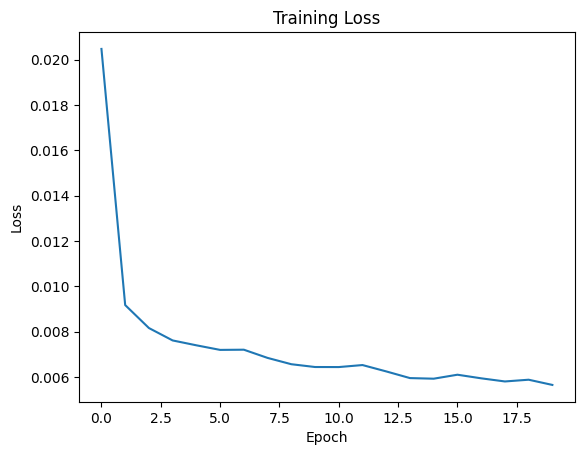

In [14]:
# Training loop
model.train()
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [15]:
# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    predictions = model(X_test_tensor).cpu().numpy()
    actuals = y_test_tensor.numpy()

# Inverse transform predictions and actuals
predictions_inverse = scaler_target.inverse_transform(predictions)
actuals_inverse = scaler_target.inverse_transform(actuals)

# Metrics
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"Solar - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


Solar - MAE: 33.32, RMSE: 60.18, R²: 0.89


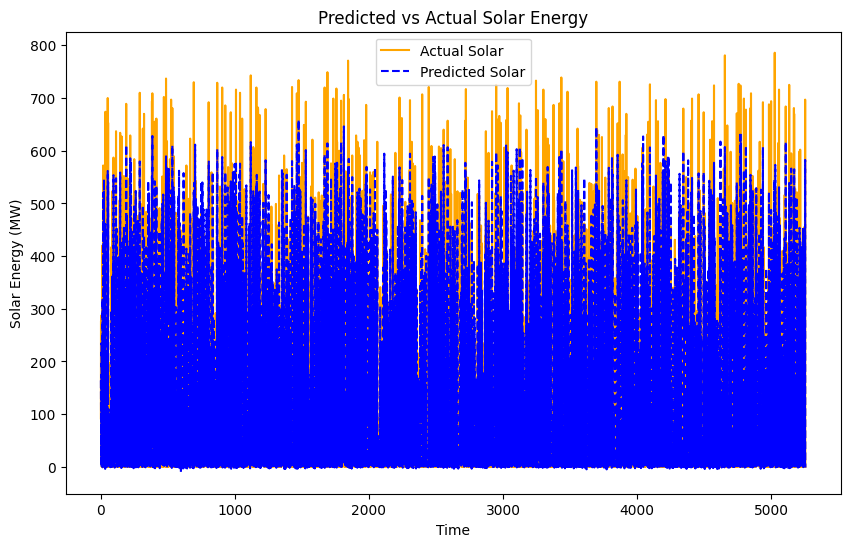

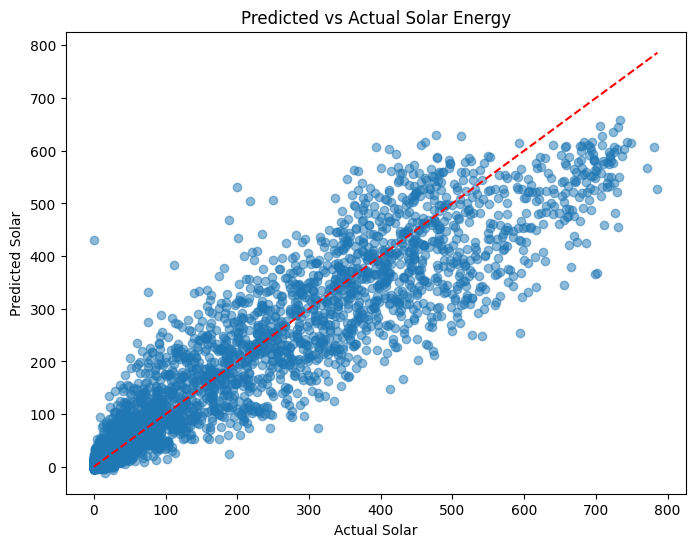

In [16]:
# Plot predicted vs actual solar energy
plt.figure(figsize=(10, 6))
plt.plot(actuals_inverse, label="Actual Solar", color="orange")
plt.plot(predictions_inverse, label="Predicted Solar", color="blue", linestyle="--")
plt.legend()
plt.title("Predicted vs Actual Solar Energy")
plt.xlabel("Time")
plt.ylabel("Solar Energy (MW)")
plt.show()

# Scatter plot for predicted vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(actuals_inverse, predictions_inverse, alpha=0.5)
plt.title("Predicted vs Actual Solar Energy")
plt.xlabel("Actual Solar")
plt.ylabel("Predicted Solar")
plt.plot([0, np.max(actuals_inverse)], [0, np.max(actuals_inverse)], color="red", linestyle="--")  # Reference diagonal
plt.show()


# Demand and Wind

In [17]:
# Install dependencies
!pip install torch torchvision torchaudio matplotlib pandas scikit-learn --quiet

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query demand and wind data
demand_query = "SELECT datetime, Demand as value FROM demand_data_NE"
demand_data = pd.read_sql_query(demand_query, conn)

wind_query = "SELECT datetime, value FROM WND_data_NE"
wind_data = pd.read_sql_query(wind_query, conn)

conn.close()

# Preprocess weather data
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Add temporal features
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)


## Demand

In [19]:
# Preprocess demand data
demand_data['datetime'] = pd.to_datetime(demand_data['datetime'])

# Merge weather and demand data
merged_demand = pd.merge(weather_data, demand_data, on='datetime', how='inner')

# Add temporal features
merged_demand['hour'] = merged_demand['datetime'].dt.hour
merged_demand['month'] = merged_demand['datetime'].dt.month
merged_demand['season'] = np.where(merged_demand['datetime'].dt.month.isin([12, 1, 2]), 1,
                                   np.where(merged_demand['datetime'].dt.month.isin([3, 4, 5]), 2,
                                            np.where(merged_demand['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))
merged_demand['time_of_day'] = np.where(merged_demand['datetime'].dt.hour < 6, 1,
                                        np.where(merged_demand['datetime'].dt.hour < 12, 2,
                                                 np.where(merged_demand['datetime'].dt.hour < 18, 3, 4)))

# Scale features and target
scaler_features_demand = MinMaxScaler()
scaled_features_demand = scaler_features_demand.fit_transform(merged_demand[[
    'temperature', 'dwpt', 'humidity', 'precipitation',
    'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season', 'time_of_day'
]])
scaler_target_demand = MinMaxScaler()
scaled_target_demand = scaler_target_demand.fit_transform(merged_demand[['value']])


In [20]:
# Prepare dataset for LSTM
sequence_length = 24
demand_dataset = EnergyDataset(scaled_features_demand, scaled_target_demand, sequence_length)

# Split data into train and test sets
train_size = int(0.7 * len(demand_dataset))
test_size = len(demand_dataset) - train_size
train_demand, test_demand = torch.utils.data.random_split(demand_dataset, [train_size, test_size])

# DataLoaders
train_loader_demand = DataLoader(train_demand, batch_size=batch_size, shuffle=True)
test_loader_demand = DataLoader(test_demand, batch_size=batch_size, shuffle=False)


In [21]:
# Model, optimizer, and criterion
input_size = scaled_features_demand.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model_demand = EnergyRNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


Epoch 1/20, Loss: 0.0143
Epoch 2/20, Loss: 0.0052
Epoch 3/20, Loss: 0.0043
Epoch 4/20, Loss: 0.0037
Epoch 5/20, Loss: 0.0033
Epoch 6/20, Loss: 0.0030
Epoch 7/20, Loss: 0.0028
Epoch 8/20, Loss: 0.0029
Epoch 9/20, Loss: 0.0026
Epoch 10/20, Loss: 0.0025
Epoch 11/20, Loss: 0.0025
Epoch 12/20, Loss: 0.0025
Epoch 13/20, Loss: 0.0024
Epoch 14/20, Loss: 0.0023
Epoch 15/20, Loss: 0.0024
Epoch 16/20, Loss: 0.0023
Epoch 17/20, Loss: 0.0022
Epoch 18/20, Loss: 0.0022
Epoch 19/20, Loss: 0.0022
Epoch 20/20, Loss: 0.0022


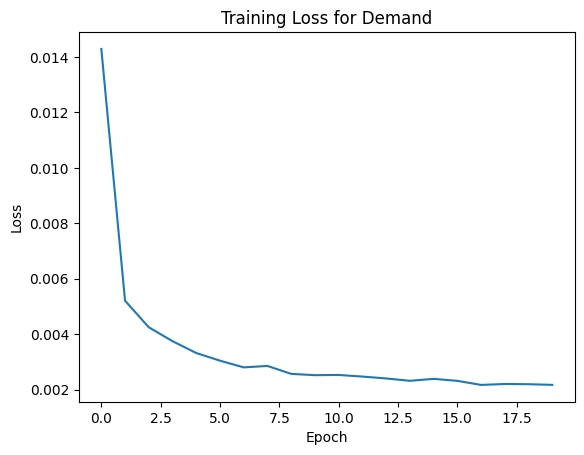

In [22]:
# Train the model
losses_demand = train_model(model_demand, train_loader_demand, optimizer_demand, criterion, num_epochs)

# Plot training loss
plt.plot(losses_demand)
plt.title("Training Loss for Demand")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [24]:
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch).cpu().numpy()
            predictions.extend(outputs)
            actuals.extend(y_batch.numpy())

    # Inverse transform predictions and actuals
    predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals_inverse = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
    return predictions_inverse, actuals_inverse


In [25]:
# Evaluate the model
predictions_demand, actuals_demand = evaluate_model(model_demand, test_loader_demand, scaler_target_demand)

# Metrics
mae_demand = mean_absolute_error(actuals_demand, predictions_demand)
rmse_demand = np.sqrt(mean_squared_error(actuals_demand, predictions_demand))
r2_demand = r2_score(actuals_demand, predictions_demand)

print(f"Demand - MAE: {mae_demand:.2f}, RMSE: {rmse_demand:.2f}, R²: {r2_demand:.2f}")


Demand - MAE: 559.09, RMSE: 724.89, R²: 0.91


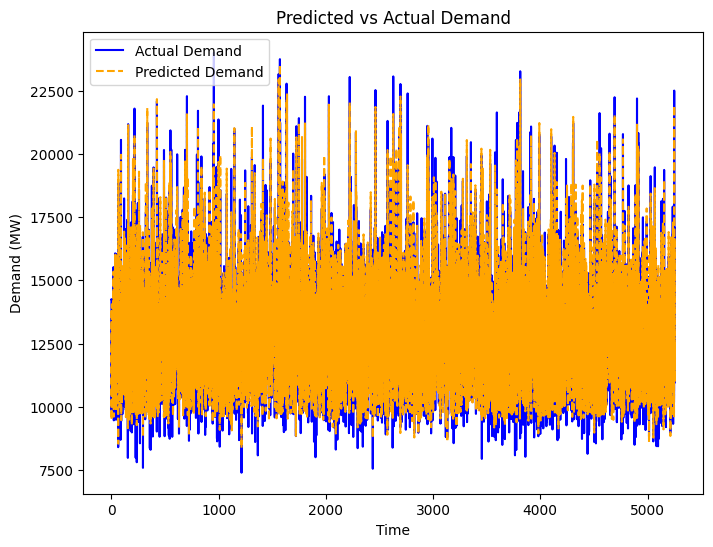

In [26]:
# Visualize predicted vs actual demand
plt.figure(figsize=(8, 6))
plt.plot(actuals_demand, label="Actual Demand", color="blue")
plt.plot(predictions_demand, label="Predicted Demand", linestyle="--", color="orange")
plt.title("Predicted vs Actual Demand")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.legend()
plt.show()


## Wind

In [27]:
# Preprocess wind data
wind_data['datetime'] = pd.to_datetime(wind_data['datetime'])

# Merge weather and wind data
merged_wind = pd.merge(weather_data, wind_data, on='datetime', how='inner')

# Add temporal features
merged_wind['hour'] = merged_wind['datetime'].dt.hour
merged_wind['month'] = merged_wind['datetime'].dt.month
merged_wind['season'] = np.where(merged_wind['datetime'].dt.month.isin([12, 1, 2]), 1,
                                 np.where(merged_wind['datetime'].dt.month.isin([3, 4, 5]), 2,
                                          np.where(merged_wind['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))
merged_wind['time_of_day'] = np.where(merged_wind['datetime'].dt.hour < 6, 1,
                                      np.where(merged_wind['datetime'].dt.hour < 12, 2,
                                               np.where(merged_wind['datetime'].dt.hour < 18, 3, 4)))

# Scale features and target
scaler_features_wind = MinMaxScaler()
scaled_features_wind = scaler_features_wind.fit_transform(merged_wind[[
    'temperature', 'dwpt', 'humidity', 'precipitation',
    'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season', 'time_of_day'
]])
scaler_target_wind = MinMaxScaler()
scaled_target_wind = scaler_target_wind.fit_transform(merged_wind[['value']])


In [28]:
# Prepare dataset for LSTM
sequence_length = 24
wind_dataset = EnergyDataset(scaled_features_wind, scaled_target_wind, sequence_length)

# Split data into train and test sets
train_size = int(0.7 * len(wind_dataset))
test_size = len(wind_dataset) - train_size
train_wind, test_wind = torch.utils.data.random_split(wind_dataset, [train_size, test_size])

# DataLoaders
train_loader_wind = DataLoader(train_wind, batch_size=batch_size, shuffle=True)
test_loader_wind = DataLoader(test_wind, batch_size=batch_size, shuffle=False)


In [29]:
# Model, optimizer, and criterion
input_size = scaled_features_wind.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model_wind = EnergyRNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer_wind = torch.optim.Adam(model_wind.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


Epoch 1/20, Loss: 0.0333
Epoch 2/20, Loss: 0.0269
Epoch 3/20, Loss: 0.0250
Epoch 4/20, Loss: 0.0242
Epoch 5/20, Loss: 0.0233
Epoch 6/20, Loss: 0.0227
Epoch 7/20, Loss: 0.0221
Epoch 8/20, Loss: 0.0216
Epoch 9/20, Loss: 0.0210
Epoch 10/20, Loss: 0.0206
Epoch 11/20, Loss: 0.0200
Epoch 12/20, Loss: 0.0194
Epoch 13/20, Loss: 0.0192
Epoch 14/20, Loss: 0.0186
Epoch 15/20, Loss: 0.0184
Epoch 16/20, Loss: 0.0183
Epoch 17/20, Loss: 0.0180
Epoch 18/20, Loss: 0.0172
Epoch 19/20, Loss: 0.0166
Epoch 20/20, Loss: 0.0163


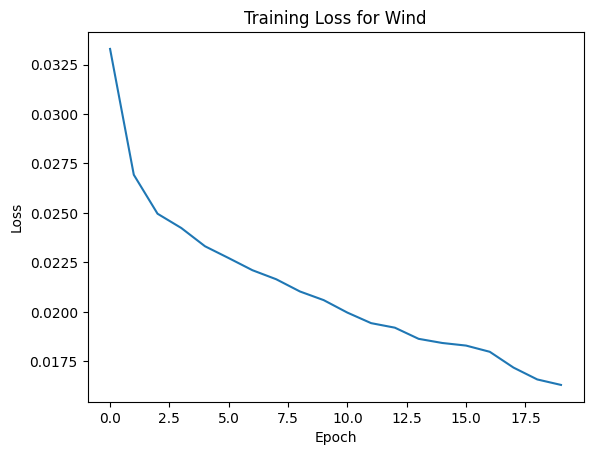

In [30]:
# Train the model
losses_wind = train_model(model_wind, train_loader_wind, optimizer_wind, criterion, num_epochs)

# Plot training loss
plt.plot(losses_wind)
plt.title("Training Loss for Wind")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [31]:
# Evaluate the model
predictions_wind, actuals_wind = evaluate_model(model_wind, test_loader_wind, scaler_target_wind)

# Metrics
mae_wind = mean_absolute_error(actuals_wind, predictions_wind)
rmse_wind = np.sqrt(mean_squared_error(actuals_wind, predictions_wind))
r2_wind = r2_score(actuals_wind, predictions_wind)

print(f"Wind - MAE: {mae_wind:.2f}, RMSE: {rmse_wind:.2f}, R²: {r2_wind:.2f}")


Wind - MAE: 123.72, RMSE: 157.36, R²: 0.70


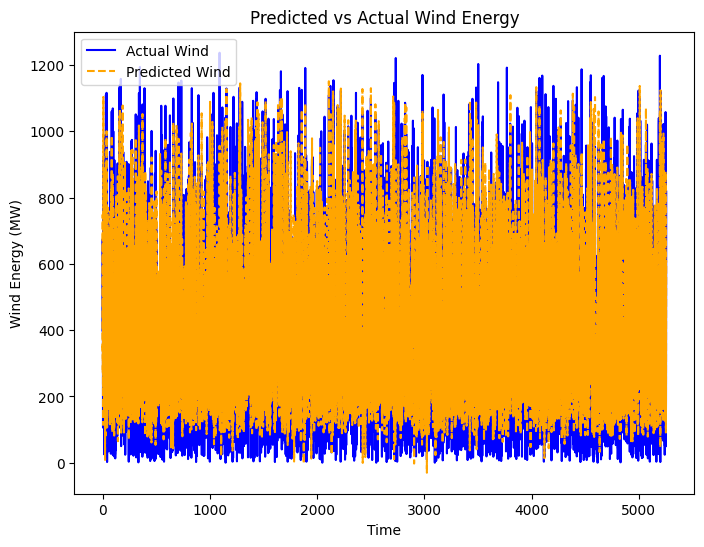

In [32]:
# Visualize predicted vs actual wind energy
plt.figure(figsize=(8, 6))
plt.plot(actuals_wind, label="Actual Wind", color="blue")
plt.plot(predictions_wind, label="Predicted Wind", linestyle="--", color="orange")
plt.title("Predicted vs Actual Wind Energy")
plt.xlabel("Time")
plt.ylabel("Wind Energy (MW)")
plt.legend()
plt.show()
